# Tugas Besar DKA Kelompok 4

## Penentuan Karyawan Terbaik Berdasarkan Skor Performa dan Rating Menggunakan sistem Fuzzy

### Anggota: 
EMIR ISMAIL ATTHARIQ - 103012300103 

FIGO MANDALA -  

RIYAN PERMANA PURBA - 103012330471 

 

## Import

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from IPython.display import display, Markdown


## === 1. Load & Preprocess Data ===

In [187]:
def preprocess(df):
    # Map performance scores to numerical values
    perf_map = {
        'PIP': 1,
        'Needs Improvement': 2,
        'Fully Meets': 3,
        'Exceeds': 4,
    }
    
    df['Performance Score Num'] = df['Performance Score'].map(perf_map)
    df['Full Name'] = df['FirstName'] + ' ' + df['LastName']
    return df.dropna()

# Load data
url = "https://raw.githubusercontent.com/FigoMandala/ieayam/main/EMPLOYEEsss.csv"
df = pd.read_csv(url)
df = preprocess(df)

## === 2. Membership Functions ===

In [188]:
def trapezoid(x, a, b, c, d):
    return np.maximum(0, np.minimum(np.minimum((x - a)/(b - a + 1e-6), 1), (d - x)/(d - c + 1e-6)))

def triangle(x, a, b, c):
    return np.maximum(0, np.minimum((x - a)/(b - a + 1e-6), (c - x)/(c - b + 1e-6)))

# Performance membership functions
def perf_less(x): return trapezoid(x, 0, 1, 2, 3)
def perf_avg(x): return triangle(x, 2, 3, 4)
def perf_good(x): return trapezoid(x, 3, 4, 5, 5)

# Rating membership functions
def rating_low(x): return trapezoid(x, 1, 1, 2, 3)
def rating_mid(x): return trapezoid(x, 2, 3, 4, 5)
def rating_high(x): return trapezoid(x, 4, 5, 5, 6)

# Output membership functions
def layak_not(x): return trapezoid(x, 0, 0, 30, 50)
def layak_consider(x): return triangle(x, 40, 60, 80)
def layak_yes(x): return trapezoid(x, 70, 85, 100, 100)

output_x = np.linspace(0, 100, 1000)


## === 3. Defuzzification ===

In [189]:
def defuzz_center_of_gravity(aggregated_mf):
    numerator = np.sum(aggregated_mf * output_x)
    denominator = np.sum(aggregated_mf)
    return numerator / (denominator+ 1e-6 ) 


## === 4. Fuzzy Rules ===

In [190]:

rules = [
    (perf_good, rating_high, 'layak_yes', 90),
    (perf_good, rating_mid, 'layak_yes', 90),
    (perf_good, rating_low, 'layak_consider', 60),
    (perf_avg, rating_high, 'layak_yes', 90),
    (perf_avg, rating_mid, 'layak_consider', 60),
    (perf_avg, rating_low, 'layak_not', 30),
    (perf_less, rating_high, 'layak_consider', 60),
    (perf_less, rating_mid, 'layak_not', 30),
    (perf_less, rating_low, 'layak_not', 30),
]

## === 5. Mamdani Inference ===

In [191]:
def fuzzy_mamdani(perf_val, rating_val):
    memberships = []
    for perf_f, rating_f, out_m, _ in rules:
        mu_perf = perf_f(perf_val)
        mu_rating = rating_f(rating_val)
        firing_strength = np.minimum(mu_perf, mu_rating)
        memberships.append((firing_strength, out_m))

    aggregated = np.zeros_like(output_x)
    for strength, out_m in memberships:
        if strength == 0:
            continue
        if out_m == 'layak_not':
            mf = layak_not(output_x) * strength
        elif out_m == 'layak_consider':
            mf = layak_consider(output_x) * strength
        else:
            mf = layak_yes(output_x) * strength
        aggregated = np.maximum(aggregated, mf)

    return defuzz_center_of_gravity(aggregated)


## === 6. Sugeno Inference ===

In [192]:
def fuzzy_sugeno(perf_val, rating_val):
    numerator = 0
    denominator = 0
    for perf_f, rating_f, _, out_s in rules:
        mu_perf = perf_f(perf_val)
        mu_rating = rating_f(rating_val)
        w = np.minimum(mu_perf, mu_rating)
        numerator += w * out_s
        denominator += w
    return numerator / (denominator + 1e-6)  


## === 7. Classification Functions ===

In [193]:
def classify_kelayakan(value):
    if value < 40:
        return 'Tidak Layak'
    elif value <= 70:
        return 'Dipertimbangkan'
    else:
        return 'Layak'

def label_from_perf(perf_num):
    if perf_num <= 2:
        return 'Kurang'
    elif perf_num == 3:
        return 'Rata-Rata'
    else:
        return 'Memuaskan'
        
def label_from_rating(rating):
    if rating > 4.0:
        return 'Tinggi'
    elif rating >= 3.0:
        return 'Sedang'
    else:
        return 'Rendah'

        
def true_label(perf_label, rating_label):
    rules = {
        ('Memuaskan', 'Tinggi'): 'Layak',
        ('Memuaskan', 'Sedang'): 'Layak',
        ('Memuaskan', 'Rendah'): 'Dipertimbangkan',
        ('Rata-Rata', 'Tinggi'): 'Layak',
        ('Rata-Rata', 'Sedang'): 'Dipertimbangkan',
        ('Rata-Rata', 'Rendah'): 'Tidak Layak',
        ('Kurang', 'Tinggi'): 'Dipertimbangkan',
        ('Kurang', 'Sedang'): 'Tidak Layak',
        ('Kurang', 'Rendah'): 'Tidak Layak',
    }
    return rules.get((perf_label, rating_label), 'Tidak Diketahui')



## === 8. Calculate Scores ===

In [194]:

df['Mamdani_Score'] = df.apply(lambda r: fuzzy_mamdani(r['Performance Score Num'], r['Current Employee Rating']), axis=1)
df['Sugeno_Score'] = df.apply(lambda r: fuzzy_sugeno(r['Performance Score Num'], r['Current Employee Rating']), axis=1)

df['Mamdani_Class'] = df['Mamdani_Score'].apply(classify_kelayakan)
df['Sugeno_Class'] = df['Sugeno_Score'].apply(classify_kelayakan)

df['Performance_Label'] = df['Performance Score Num'].apply(label_from_perf)
df['Rating_Label'] = df['Current Employee Rating'].apply(label_from_rating)
df['True_Label'] = df.apply(lambda r: true_label(r['Performance_Label'], r['Rating_Label']), axis=1)


## === 9. Evaluation ===

In [195]:

print('=== Evaluasi Mamdani ===')
print('Accuracy:', accuracy_score(df['True_Label'], df['Mamdani_Class']))
print('F1 Score:', f1_score(df['True_Label'], df['Mamdani_Class'], average='weighted'))

print('\n=== Evaluasi Sugeno ===')
print('Accuracy:', accuracy_score(df['True_Label'], df['Sugeno_Class']))
print('F1 Score:', f1_score(df['True_Label'], df['Sugeno_Class'], average='weighted'))


=== Evaluasi Mamdani ===
Accuracy: 0.994413407821229
F1 Score: 0.9944283845631513

=== Evaluasi Sugeno ===
Accuracy: 0.994413407821229
F1 Score: 0.9944283845631513


## === 10. Display Results ===

In [196]:
# Configure display options
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Prepare sorted results
df_mamdani_sorted = df[['EmpID', 'Full Name', 'Performance Score', 'Current Employee Rating', 
                        'Mamdani_Score', 'Mamdani_Class', 'True_Label']].sort_values(by='Mamdani_Score', ascending=False)

df_sugeno_sorted = df[['EmpID', 'Full Name', 'Performance Score', 'Current Employee Rating', 
                       'Sugeno_Score', 'Sugeno_Class', 'True_Label']].sort_values(by='Sugeno_Score', ascending=False)

# Display results
display(Markdown("### 🔷 Hasil Sistem Fuzzy Mamdani (Tertinggi ke Terendah)"))
display(df_mamdani_sorted.reset_index(drop=True))

display(Markdown("### 🔶 Hasil Sistem Fuzzy Sugeno (Tertinggi ke Terendah)"))
display(df_sugeno_sorted.reset_index(drop=True))

### 🔷 Hasil Sistem Fuzzy Mamdani (Tertinggi ke Terendah)

,EmpID,Full Name,Performance Score,Current Employee Rating,Mamdani_Score,Mamdani_Class,True_Label
0,3493,Hugo Clay,Fully Meets,5,88.31,Layak,Layak
1,3660,Aron Hester,Exceeds,3,88.31,Layak,Layak
2,3983,Kaylie Velazquez,Exceeds,3,88.31,Layak,Layak
3,3980,Carmen Atkins,Exceeds,3,88.31,Layak,Layak
4,2588,Callum Ford,Fully Meets,5,88.31,Layak,Layak
5,2506,Trey Johnston,Fully Meets,5,88.31,Layak,Layak
6,2456,Odin Sampson,Fully Meets,5,88.31,Layak,Layak
7,2713,Abagail Villanueva,Fully Meets,5,88.31,Layak,Layak
8,3040,Areli Torres,Fully Meets,5,88.31,Layak,Layak
9,2148,Joel Koch,Exceeds,5,88.31,Layak,Layak


### 🔶 Hasil Sistem Fuzzy Sugeno (Tertinggi ke Terendah)

,EmpID,Full Name,Performance Score,Current Employee Rating,Sugeno_Score,Sugeno_Class,True_Label
0,3493,Hugo Clay,Fully Meets,5,90.00,Layak,Layak
1,3660,Aron Hester,Exceeds,3,90.00,Layak,Layak
2,3983,Kaylie Velazquez,Exceeds,3,90.00,Layak,Layak
3,3980,Carmen Atkins,Exceeds,3,90.00,Layak,Layak
4,2588,Callum Ford,Fully Meets,5,90.00,Layak,Layak
5,2506,Trey Johnston,Fully Meets,5,90.00,Layak,Layak
6,2456,Odin Sampson,Fully Meets,5,90.00,Layak,Layak
7,2713,Abagail Villanueva,Fully Meets,5,90.00,Layak,Layak
8,3040,Areli Torres,Fully Meets,5,90.00,Layak,Layak
9,2148,Joel Koch,Exceeds,5,90.00,Layak,Layak


## === 11. Visualization ===

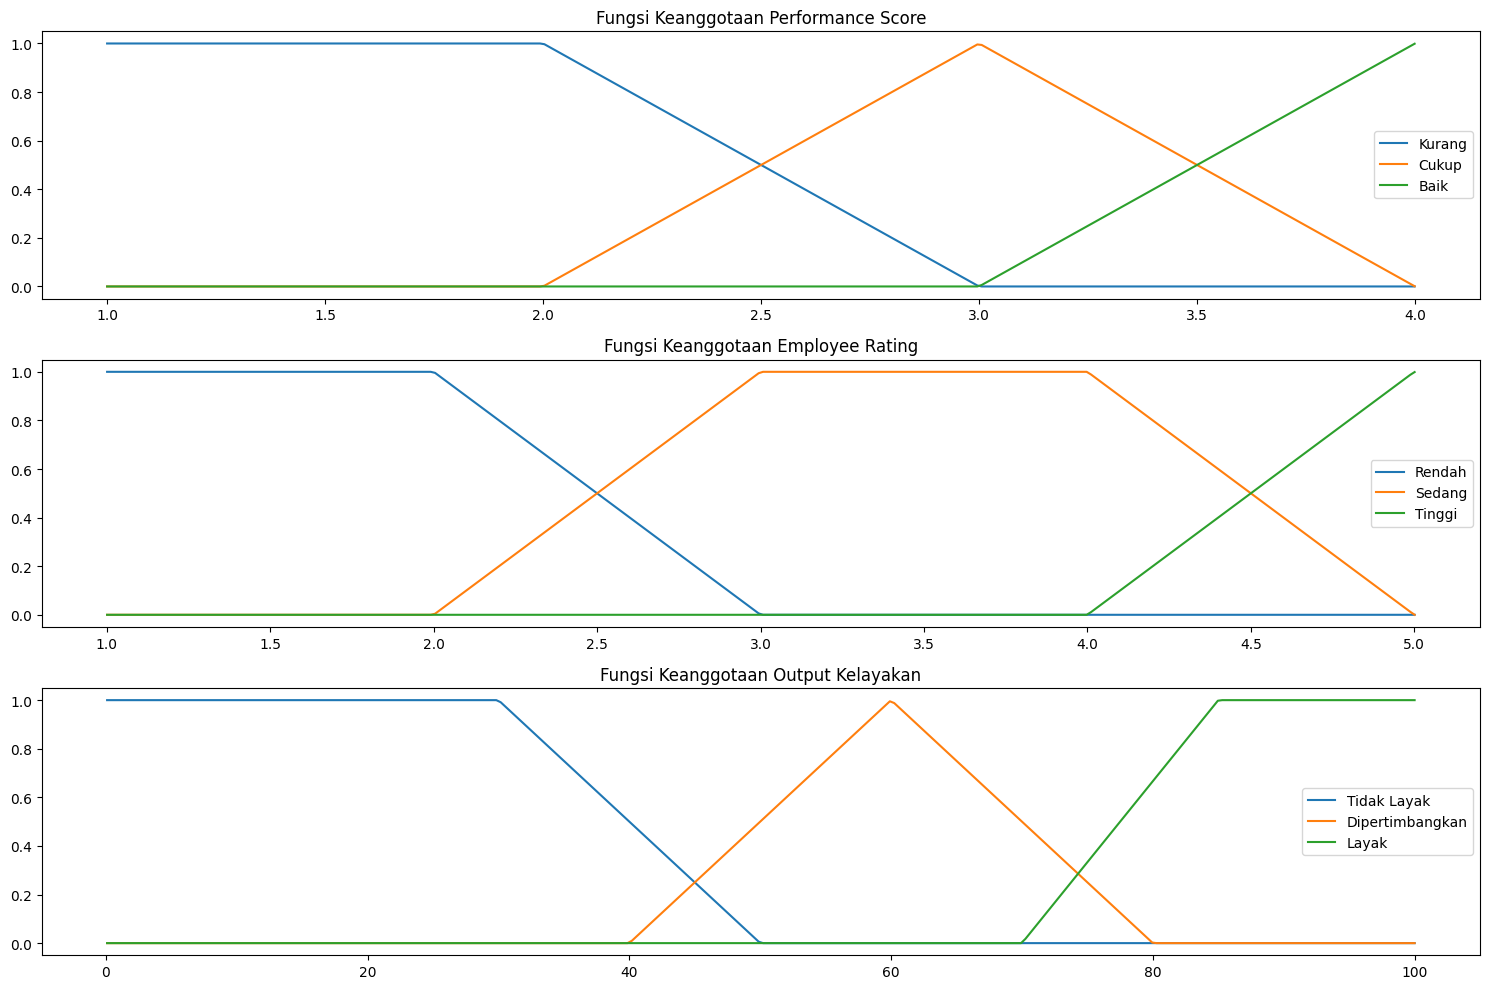

In [197]:

plt.figure(figsize=(15, 10))

# Performance Membership
plt.subplot(3, 1, 1)
x_perf = np.linspace(1, 3.999, 300)
plt.plot(x_perf, perf_less(x_perf), label='Kurang')
plt.plot(x_perf, perf_avg(x_perf), label='Cukup')
plt.plot(x_perf, perf_good(x_perf), label='Baik')
plt.title("Fungsi Keanggotaan Performance Score")
plt.legend()

# Rating Membership
plt.subplot(3, 1, 2)
x_rating = np.linspace(1.001, 5.001, 300)
plt.plot(x_rating, rating_low(x_rating), label='Rendah')
plt.plot(x_rating, rating_mid(x_rating), label='Sedang')
plt.plot(x_rating, rating_high(x_rating), label='Tinggi')
plt.title("Fungsi Keanggotaan Employee Rating")
plt.legend()

# Output Membership
plt.subplot(3, 1, 3)
x_output = np.linspace(0.1, 99.999, 300)
plt.plot(x_output, layak_not(x_output), label='Tidak Layak')
plt.plot(x_output, layak_consider(x_output), label='Dipertimbangkan')
plt.plot(x_output, layak_yes(x_output), label='Layak')
plt.title("Fungsi Keanggotaan Output Kelayakan")
plt.legend()

plt.tight_layout()
plt.show()